In [93]:
import os
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-dd688c74-05b3-6675-591b-3422584e024a)


In [94]:
import numpy as np
import typing
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

**Data Collection & Pre-Processing;**

Data description;a real-world traffic speed dataset named PeMSD7. PeMSD7 was collected from Caltrans Performance Measurement System (PeMS) in real-time by over 39, 000 sensor stations, deployed across the major metropolitan areas of California state highway system. The dataset is also aggregated into 5-minute interval from 30-second data samples. We randomly select a medium and a large scale among the District 7 of California containing 228 and 1, 026 stations, labeled as PeMSD7(M) and PeMSD7(L), respectively, as data sources. The time range of PeMSD7 dataset is in the weekdays of May and June of 2012. Dataset PeMSD7(M/L) is now available under dataset folder.

In [96]:
route_distances_raw = pd.read_csv(("PeMSD7_W_1026.csv"), header=None)
route_distances = pd.read_csv(("PeMSD7_W_1026.csv"), header=None).to_numpy()

In [97]:
print(f"route_distances shape={route_distances.shape}")

route_distances shape=(1026, 1026)


In [98]:
speeds_array_raw = pd.read_csv(("PeMSD7_V_1026.csv"), header=None)
speeds_array = pd.read_csv(("PeMSD7_V_1026.csv"), header=None).to_numpy()

In [99]:
print(f"speeds_array shape={speeds_array.shape}")

speeds_array shape=(12672, 1026)


**Sub-sampling roads;**
To reduce the problem size and make the training faster, we will only work with a sample of 26 roads out of the 228 roads in the dataset. We have chosen the roads by starting from road 0, choosing the 5 closest roads to it, and continuing this process until we get 25 roads. You can choose any other subset of the roads. We chose the roads in this way to increase the likelihood of having roads with correlated speed timeseries. sample_routes contains the IDs of the selected roads.

In [100]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]

In [101]:
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

In [102]:
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


**Data visualization And EDA;**

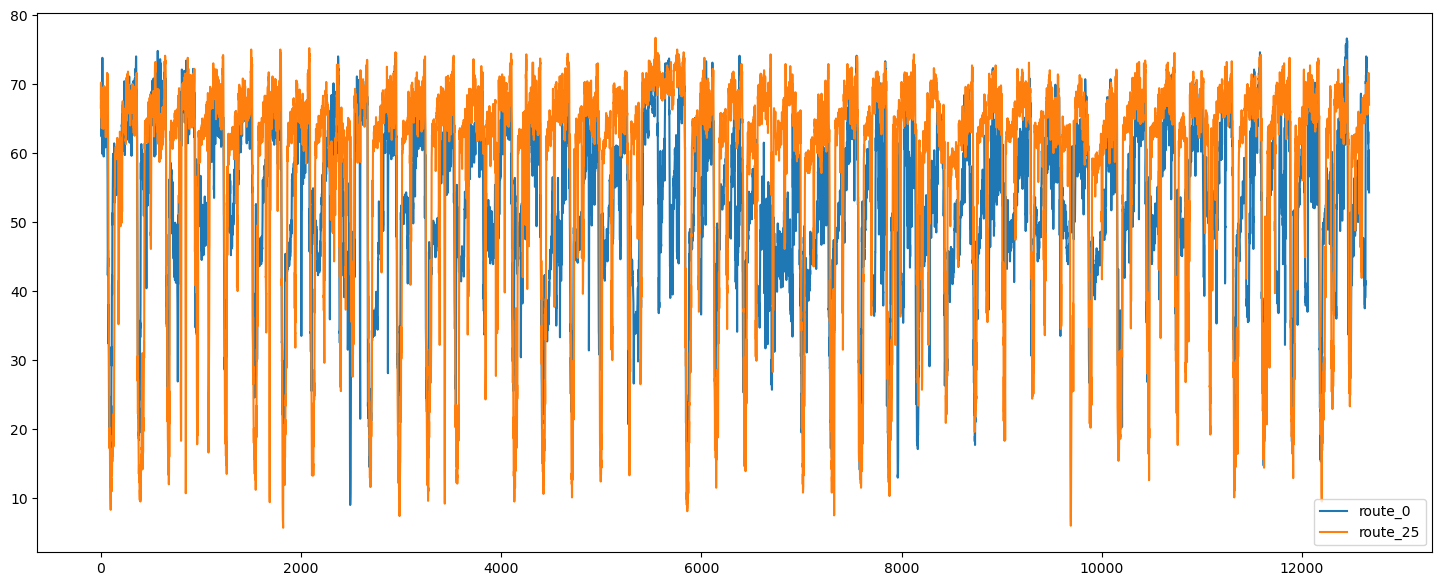

In [103]:
plt.figure(figsize=(18, 7))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])
plt.show()

We can also visualize the correlation between the timeseries in different routes.



Text(0, 0.5, 'road number')

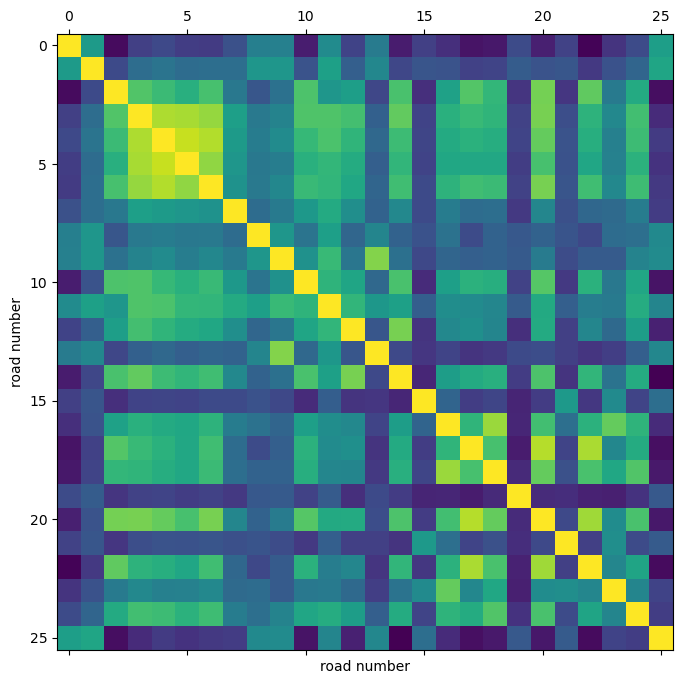

In [104]:
plt.figure(figsize=(8,8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

Split and normalize data;

In [105]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

In [106]:
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

In [107]:
print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


**Creating Torch Datasets**;

Next, we create the datasets for our forecasting problem. The forecasting problem can be stated as follows: given a sequence of the road speed values at times t+1, t+2, ..., t+T, we want to predict the future values of the roads speed for times t+T+1, ..., t+T+h. So for each time t the inputs to our model are T vectors each of size N and the targets are h vectors each of size N, where N is the number of roads.

We write 'TimeSeriesDataset' function takes the input and target sequences are manually sliced from the data_array. The function create_torch_dataset() below takes as input a numpy.ndarray and returns a dataloader instance. In this function input_sequence_length=T and forecast_horizon=h.

The argument multi_horizon needs more explanation. Assume forecast_horizon=3. If multi_horizon=True then the model will make a forecast for time steps t+T+1, t+T+2, t+T+3. So the target will have shape (T,3). But if multi_horizon=False, the model will make a forecast only for time step t+T+3 and so the target will have shape (T, 1).

You may notice that the input tensor in each batch has shape (batch_size, input_sequence_length, num_routes, 1). The last dimension is added to make the model more general: at each time step, the input features for each raod may contain multiple timeseries. For instance, one might want to use temperature timeseries in addition to historical values of the speed as input features. In this example, however, the last dimension of the input is always 1.

We use the last 12 values of the speed in each road to forecast the speed for 3 time steps ahead:

In [108]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

In [109]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data_array, input_sequence_length, forecast_horizon, multi_horizon=True):
        """
        Args:
            data_array: np.ndarray with shape `(num_time_steps, num_routes)`
            input_sequence_length: Length of the input sequence (in number of timesteps).
            forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
                              `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value 
                              of the timeseries `forecast_horizon` steps ahead (only one value).
            multi_horizon: See `forecast_horizon`.
        """
        self.data_array = data_array
        self.input_sequence_length = input_sequence_length
        self.forecast_horizon = forecast_horizon
        self.multi_horizon = multi_horizon
        
        self.inputs = self._create_inputs()
        self.targets = self._create_targets()

    def _create_inputs(self):
        # Create input sequences
        num_samples = len(self.data_array) - self.forecast_horizon - self.input_sequence_length + 1
        inputs = [
            self.data_array[i:i + self.input_sequence_length, :]
            for i in range(num_samples)
        ]
        return np.expand_dims(np.array(inputs), axis=-1)

    def _create_targets(self):
        # Create target sequences
        if self.multi_horizon:
            num_samples = len(self.data_array) - self.input_sequence_length - self.forecast_horizon + 1
            targets = [
                self.data_array[i + self.input_sequence_length:i + self.input_sequence_length + self.forecast_horizon, :]
                for i in range(num_samples)
            ]
        else:
            num_samples = len(self.data_array) - self.input_sequence_length - self.forecast_horizon + 1
            targets = [
                self.data_array[i + self.input_sequence_length + self.forecast_horizon - 1, :]
                for i in range(num_samples)
            ]
        return np.array(targets)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

def create_torch_dataset(data_array, input_sequence_length, forecast_horizon, batch_size=128, shuffle=True, multi_horizon=True):
    """
    Creates a PyTorch DataLoader from numpy array.
    
    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: Forecast horizon.
        batch_size: Batch size for DataLoader.
        shuffle: Whether to shuffle the dataset.
        multi_horizon: Whether the target is a single point or a horizon of points.
        
    Returns:
        A DataLoader instance.
    """
    dataset = TimeSeriesDataset(
        data_array, input_sequence_length, forecast_horizon, multi_horizon
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [110]:
train_dataset, val_dataset = (
    create_torch_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_torch_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

Roads Graph Neural Network:

As mentioned before, we assume that the road segments form a graph. The PeMSD7 dataset has the road segments distance. The next step is to create the graph adjacency matrix from these distances.

In [111]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

The function compute_adjacency_matrix() returns a boolean adjacency matrix where 1 means there is an edge between two nodes. We use the following class to store the information about the graph

In [112]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 52


#### Visualization

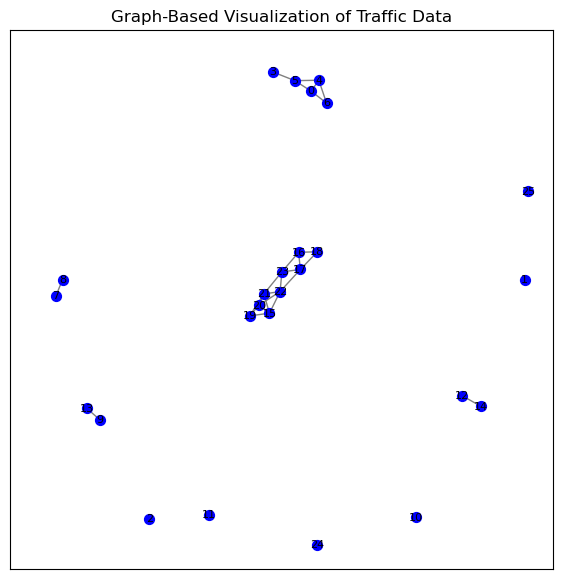

In [113]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

adj_matrix = compute_adjacency_matrix(route_distances, sigma2=0.1, epsilon=0.5)

# Create a graph from the adjacency matrix
G = nx.Graph()

# Add nodes (one for each road)
num_nodes = adj_matrix.shape[0]
for i in range(num_nodes):
    G.add_node(i)

# Add edges with weights (traffic values between roads)
for i in range(num_nodes):
    for j in range(i+1, num_nodes):  # Only considering upper triangle (to avoid duplicate edges)
        if adj_matrix[i, j] > 0:  # Consider only positive traffic values
            G.add_edge(i, j, weight=adj_matrix[i, j])

# Plotting the graph
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G, seed=42)  # Positioning the nodes
edges = G.edges(data=True)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')

# Draw the edges (thicker edges for larger weights)
nx.draw_networkx_edges(
    G, pos, edgelist=edges,
    edge_color='gray'
)

# Adding labels for the nodes
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Graph-Based Visualization of Traffic Data")
plt.show()


The above visualization will be more robust if we used the entire dataset instead of the chosen 26

##### Graph convolution layer And Network architecture:

In [114]:
from layers import GraphConv

By applying the graph convolution layer to the input tensor, we get another tensor containing the nodes' representations over time (another 4D tensor). For each time step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors but also we need to process the information over time. To this end, we can pass each node's tensor through a recurrent layer. The LSTMGC layer below, first applies a graph convolution layer to the inputs and then passes the results through a LSTM layer

In [115]:
from typing import Optional

class LSTMGC(nn.Module):
    """Layer comprising a custom GraphConv layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat: int,
        out_feat: int,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        edge_index: torch.Tensor,
        graph_info,
        edge_weight: Optional[torch.Tensor] = None,
        graph_conv_params: Optional[dict] = None,
    ):
        super(LSTMGC, self).__init__()

        # Graph convolution layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(
            in_feat, out_feat, graph_info, **graph_conv_params
        )

        # LSTM layer
        self.lstm = nn.LSTM(out_feat, lstm_units, batch_first=True)

        # Dense layer
        self.dense = nn.Linear(lstm_units, output_seq_len)

        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        self.edge_index = edge_index
        self.edge_weight = edge_weight

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            inputs: torch.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """
        # Convert shape to (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = inputs.permute(2, 0, 1, 3)  # (num_nodes, batch_size, input_seq_len, in_feat)

        num_nodes, batch_size, input_seq_len, in_feat = inputs.shape

        # Apply graph convolution at each time step
        gcn_out = []
        for t in range(input_seq_len):
            # Shape at t: (num_nodes, in_feat)
            features_at_t = inputs[:, :, t, :].permute(1, 0, 2).reshape(num_nodes, -1)
            print(f"features_at_t shape before GCN: {features_at_t.shape}")
            gcn_out.append(self.graph_conv(features_at_t, self.edge_index))

        gcn_out = torch.stack(gcn_out, dim=1)  # (num_nodes, batch_size, input_seq_len, out_feat)

        # Reshape for LSTM (batch_size * num_nodes, input_seq_len, out_feat)
        gcn_out = gcn_out.permute(1, 0, 2, 3).reshape(batch_size * num_nodes, input_seq_len, -1)

        # Apply LSTM
        lstm_out, _ = self.lstm(gcn_out)  # (batch_size * num_nodes, input_seq_len, lstm_units)

        # Take the last output of the LSTM
        lstm_out = lstm_out[:, -1, :]  # (batch_size * num_nodes, lstm_units)

        # Apply Dense layer
        dense_output = self.dense(lstm_out)  # (batch_size * num_nodes, output_seq_len)

        # Reshape to (num_nodes, batch_size, output_seq_len)
        output = dense_output.reshape(batch_size, num_nodes, self.output_seq_len).permute(0, 2, 1)

        return output  # (batch_size, output_seq_len, num_nodes)

##### Model Training

In [116]:
from torchinfo import summary  # For model summary
from torch.utils.tensorboard import SummaryWriter  # For logging and visualization
import os

# Directory for TensorBoard logs
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

In [117]:
from torch.optim import RMSprop

# Create dataloaders
train_loader = train_dataset
val_loader = val_dataset
test_loader = test_dataset

# Model configuration
in_feat = 64
batch_size = 64
epochs = 50
input_sequence_length = 12
forecast_horizon = 3
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

# `graph.edges` is a tuple of edge indices
edge_index = torch.tensor(graph.edges, dtype=torch.long)

# Define the model
st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    edge_index = edge_index,
    graph_info=graph,
    graph_conv_params = graph_conv_params,
)

# Define the optimizer and loss function
optimizer = RMSprop(st_gcn.parameters(), lr=0.0002)
criterion = nn.MSELoss()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
st_gcn.to(device)

# Training loop
for epoch in range(epochs):
    st_gcn.train()
    train_loss = 0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        # Forward pass
        outputs = st_gcn(batch_inputs)

        # Compute loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    st_gcn.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = st_gcn(batch_inputs)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

    print(
        f"Epoch {epoch + 1}/{epochs}, "
        f"Train Loss: {train_loss / len(train_loader):.4f}, "
        f"Val Loss: {val_loss / len(val_loader):.4f}"
    )

print("Training complete.")

# Test phase
st_gcn.eval()
test_loss = 0
with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        outputs = st_gcn(batch_inputs)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

features_at_t shape before GCN: torch.Size([26, 64])
features shape: torch.Size([26, 64]), weight shape: torch.Size([64, 10])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA_scatter_add_)

In [ ]:
from torchinfo import summary  # For model summary
from torch.utils.tensorboard import SummaryWriter  # For logging and visualization
import os

# Directory for TensorBoard logs
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Model Summary
summary(st_gcn, input_size=(batch_size, input_sequence_length, graph.num_nodes, in_feat))

# Plotting the model (optional, requires graphviz and torchviz)
try:
    from torchviz import make_dot
    dummy_input = torch.randn(batch_size, input_sequence_length, graph.num_nodes, in_feat).to(device)
    model_graph = make_dot(st_gcn(dummy_input), params=dict(st_gcn.named_parameters()))
    model_graph.render("st_gcn_model", format="png", cleanup=True)
except ImportError:
    print("Install torchviz to visualize the model graph.")

# Training with early stopping
best_val_loss = float("inf")
patience = 10
patience_counter = 0

for epoch in range(epochs):
    st_gcn.train()
    train_loss = 0

    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        # Forward pass
        outputs = st_gcn(batch_inputs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    st_gcn.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = st_gcn(batch_inputs)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

    # Log metrics to TensorBoard
    writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)
    writer.add_scalar("Loss/val", val_loss / len(val_loader), epoch)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(st_gcn.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print(
        f"Epoch {epoch + 1}/{epochs}, "
        f"Train Loss: {train_loss / len(train_loader):.4f}, "
        f"Val Loss: {val_loss / len(val_loader):.4f}"
    )

# Close the TensorBoard writer
writer.close()

# Load the best model for evaluation
st_gcn.load_state_dict(torch.load("best_model.pth"))

# Test phase
st_gcn.eval()
test_loss = 0
with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        outputs = st_gcn(batch_inputs)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
